### **Условия домашки**

#### **Задание:**

Ваша задача - подготовить почву для проведения эксперимента в агрегаторе такси.

Эксперимент заключается в смене алгоритма назначения водителя на заказ. Задача нового алгоритма - ускорить назначение (и таким образом снизить количество клиентских отмен до назначения).

Изучите исторические данные по времени назначения в [файле](https://drive.google.com/drive/folders/1-HiBCppVmU2f5C-Q-ekBw-v0ztxUqbs7)

#### **Шаги:**

1. Предположите, что минимально значимое (с точки зрения бизнеса) изменение времени назначения вследствие внедрения нового алгоритма составляет 5 секунд. Рассчитайте необходимое количество наблюдений для проведения подобного A/B теста.
2. Избавьтесь от выбросов (с помощью визуализации или квантильного анализа). Вновь рассчитайте время, необходимое для проведения эксперимента. На сколько оно уменьшилось?
3. Замените абсолютную таргет-метрику (время до назначения) на бинарную метрику (флаг “назначение длилось дольше чем Х секунд”). Возьмите для начала Х = 120 секунд.
4. Создайте у себя в тетрадке функцию uplift_bin_calc, которая берет на вход MDE и дисперсию выборки, а на выходе дает необходимое количество наблюдений для проведения A/B теста.
5. Чему равно необходимое количество наблюдений для проведения эксперимента после замены абсолютной таргет-метрики на бинарную? В качестве MDE бинарной метрики необходимо взять значение, соответствующее MDE абсолютной метрики (которое равно 5 секунд). Рассчитайте также необходимое количество наблюдений для абсолютной таргет-метрики.
6. Рассмотрите другие пороги Х. Постройте цикл, который будет пробегаться по различным значениям Х и рассчитывать необходимое количество наблюдений. Сохраните результаты в датафрейм.
7. Изобразите на графике зависимость необходимого количества наблюдений от порога Х.

**В результате у вас получится файл в формате .ipynb, в котором будут выполнены все шаги предложенные в задании.**

---


### **Решение**

#### Подготовка (импорт данных, установка импорт библиотек

In [15]:
import scipy
import numpy as np
import pandas as pd
from math import sqrt
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
file_name = 'Контроль длительности. Домашнее задание (исходник).csv'
timestamp_format = '%d.%m.%Y %H:%M:%S'

data = pd.read_csv(file_name, sep=';')
data['order_time'] = pd.to_datetime(data['order_time'], format=timestamp_format)
data['assign_time'] = pd.to_datetime(data['assign_time'], format=timestamp_format)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5896 entries, 0 to 5895
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id_order     5896 non-null   int64         
 1   order_time   5896 non-null   datetime64[ns]
 2   assign_time  5896 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 138.3 KB


***1. Предположите, что минимально значимое (с точки зрения бизнеса) изменение времени назначения вследствие внедрения нового алгоритма составляет 5 секунд. Рассчитайте необходимое количество наблюдений для проведения подобного A/B теста.***

In [17]:
data['delta'] = (data['assign_time'] - data['order_time']).dt.seconds
data.describe()

,id_order,delta
count,5.896000e+03,5896.000000
mean,1.145607e+07,174.974729
std,1.702173e+03,192.227905
min,1.145312e+07,0.000000
25%,1.145459e+07,95.000000
50%,1.145607e+07,141.000000
75%,1.145754e+07,187.000000
max,1.145902e+07,1235.000000


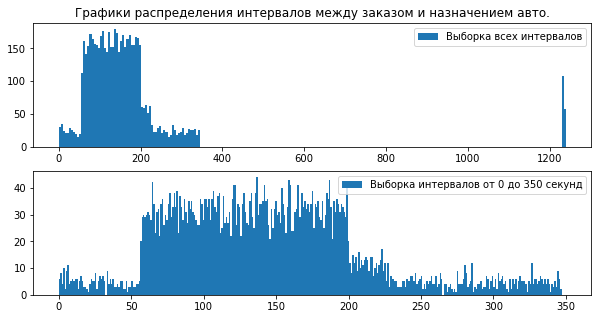

In [18]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 5))

ax[0].set_title('Графики распределения интервалов между заказом и назначением авто.')
ax[0].hist(data['delta'], np.linspace(0, 1240, 248), label='Выборка всех интервалов')
ax[0].legend()

ax[1].hist(data['delta'], np.linspace(0, 350, 350), label='Выборка интервалов от 0 до 350 секунд')
ax[1].legend()

plt.show()

Количество наблюдений посчитаем по упращенной формуле:

\begin{align}
n  =  \frac{16 \dot \sigma^2}{MDE^2}, где:
\end{align}

$n$ - количество наблюдений,  
$\sigma^2$ - дисперсия,  
$MDE$ - минимальная обнаруживаемая разница ***(по условию 5 секунд)***

In [19]:
sigma2 = np.var(data['delta'])
MDE = 5

n = (16 * sigma2) / (MDE**2)
print(f'Необходимое количество наблюдений для проведения подобного A/B теста = {int(n)}')

Необходимое количество наблюдений для проведения подобного A/B теста = 23644


***2. Избавьтесь от выбросов (с помощью визуализации или квантильного анализа). Вновь рассчитайте время, необходимое для проведения эксперимента. На сколько оно уменьшилось?***


Избавляемся от выбросов выделив 95% доверительного интервала удалив по 2.5% со стороны максимальных и минимальных значений распределения

In [20]:
data = data[data['delta']<800]

delta_min = np.quantile(data['delta'], 0.025)
delta_max = np.quantile(data['delta'], 1 - 0.025)

data_work_1 = data[(data['delta'] > delta_min) & (data['delta'] < delta_max)]
delta_min, delta_max

(28.0, 317.0)

In [21]:
sigma2 = np.var(data_work_1['delta'])
MDE = 5

n = (16 * sigma2) / MDE**2
print(f'Необходимое количество наблюдений для проведения подобного A/B теста = {int(n)}')

Необходимое количество наблюдений для проведения подобного A/B теста = 2171


***3. Замените абсолютную таргет-метрику (время до назначения) на бинарную метрику (флаг “назначение длилось дольше чем Х секунд”). Возьмите для начала Х = 120 секунд.***

In [22]:
X = 120 # секунд
data_work_2 = data_work_1.copy()
data_work_2['delta_flag_120'] = np.where(data_work_1['delta'] > X, 1, 0)
data_work_2.sample(5)

,id_order,order_time,assign_time,delta,delta_flag_120
3139,11455658,2022-08-02 03:18:34,2022-08-02 03:19:44,70,0
1156,11457387,2022-08-02 22:34:13,2022-08-02 22:37:21,188,1
4113,11458182,2022-08-01 01:09:50,2022-08-01 01:11:16,86,0
4692,11457152,2022-08-02 07:59:39,2022-08-02 08:00:58,79,0
4371,11455339,2022-08-02 08:21:36,2022-08-02 08:23:17,101,0


***4. Создайте у себя в тетрадке функцию uplift_bin_calc, которая берет на вход MDE и дисперсию выборки, а на выходе дает необходимое количество наблюдений для проведения A/B теста.***

In [23]:
def uplift_abs_calc(mde, sigma2) -> int:
    return int((16 * sigma2) / (mde**2))

# testing
print(uplift_abs_calc(5, np.var(data['delta'])))
print(uplift_abs_calc(5, np.var(data_work_1['delta'])))

2919
2171


***5. Чему равно необходимое количество наблюдений для проведения эксперимента после замены абсолютной таргет-метрики на бинарную? В качестве MDE бинарной метрики необходимо взять значение, соответствующее MDE абсолютной метрики (которое равно 5 секунд). Рассчитайте также необходимое количество наблюдений для абсолютной таргет-метрики.***

In [24]:
n_bin = int(uplift_abs_calc(5, np.var(data_work_2.loc[data_work_2['delta_flag_120'] == 1, 'delta'])))

print(f'Необходимое количество наблюдений для проведения подобного A/B теста = {int(n_bin)}')
print('Снижение количества наблюдений при замене таргет-метрики на', int(n - n_bin))

Необходимое количество наблюдений для проведения подобного A/B теста = 1233
Снижение количества наблюдений при замене таргет-метрики на 938


***6. Рассмотрите другие пороги Х. Постройте цикл, который будет пробегаться по различным значениям Х и рассчитывать необходимое количество наблюдений. Сохраните результаты в датафрейм.***

In [25]:
def uplift_bin_calc(p1,p2,x1,x2,y,delta_y):
    uplift_x = (y+delta_y-p1*x1-p2*x2)/(x1-x2)
    return uplift_x

In [26]:
df_res = pd.DataFrame(columns = ['limit','ratio_more','ratio_less','n_bin','n_abs'])

for i in range(5,60):
    mult = i*5
    c_more = data[data['delta']>=mult]['delta'].count()
    c_less = data[data['delta']<mult]['delta'].count()
    
    ratio_more = c_more/(c_more+c_less)
    ratio_less = c_less/(c_more+c_less)
    
    m_more = data[data['delta']>=mult]['delta'].mean()
    m_less = data[data['delta']<mult]['delta'].mean()
    m = data['delta'].mean()
    
    var_abs = data['delta'].var()
    var_bin = ratio_more*(1-ratio_more)

    u = uplift_bin_calc(c_more/(c_more+c_less), c_less/(c_more+c_less), m_more, m_less, m, 5)
    n_bin = uplift_abs_calc(u, var_bin)
    n_abs = uplift_abs_calc(5, var_abs)
    
    df_res = df_res.append(
        {
            'limit':mult,
            'ratio_more':ratio_more,
            'ratio_less':ratio_less,
            'n_bin':n_bin,
            'n_abs':n_abs
        }, ignore_index = True)

In [27]:
df_res

,limit,ratio_more,ratio_less,n_bin,n_abs
0,25.0,0.978185,0.021815,253.0,2919.0
1,30.0,0.973473,0.026527,296.0,2919.0
2,35.0,0.968761,0.031239,336.0,2919.0
3,40.0,0.964747,0.035253,367.0,2919.0
4,45.0,0.961257,0.038743,392.0,2919.0
5,50.0,0.958988,0.041012,406.0,2919.0
6,55.0,0.955846,0.044154,423.0,2919.0
7,60.0,0.940489,0.059511,500.0,2919.0
8,65.0,0.914660,0.085340,626.0,2919.0
9,70.0,0.886387,0.113613,759.0,2919.0


***7. Изобразите на графике зависимость необходимого количества наблюдений от порога Х.***

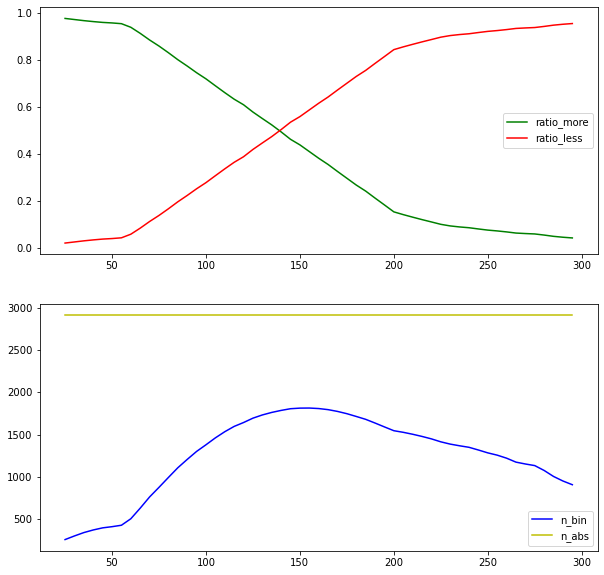

In [28]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax1.plot(df_res['limit'], df_res['ratio_more'], 'g', label='ratio_more')
ax1.plot(df_res['limit'], df_res['ratio_less'], 'r', label='ratio_less')
ax1.legend()

ax2.plot(df_res['limit'], df_res['n_bin'], 'b', label='n_bin')
ax2.plot(df_res['limit'], df_res['n_abs'], 'y', label='n_abs')
ax2.legend()

plt.show()